# (Pre-) Validation for Dataset

In [1]:
import json
import numpy as np
from tqdm import trange
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from ngsolve.webgui import Draw

from cluster.scripts.run_simulation import create_geometry

In [40]:
job_list_file = "./cluster/configs/random_scatterer_ellipsoid_box_cylinder_jobs.json"
job_list_file = "./cluster/configs/scattering_random_ellipsoid_sweep_jobs.json"
#job_list_file = "./cluster/configs/random_scatterer_ellipsoid_box_jobs.json"

In [41]:
with open(job_list_file, 'r') as f:
    jobs = json.load(f)

Draw the geometry of a Job

In [37]:
job_id = 0

params = jobs[job_id]['parameters']
geometry_config = jobs[job_id]['geometry']
solver_config = jobs[job_id]['solver']

mesh,geometry_type = create_geometry(geometry_config, params)

  → Creating tri-axial ellipsoid scatterer geometry


In [38]:
draw_file = "./bin/imgs/test_visualization.html"
clipping = { "function" : True,  "pnt" : (0,0.0,0), "vec" : (0,0,-1) }

line_1 = { "type": "lines", "position": [params['wavelength'],params['wavelength'],0, params['wavelength']+0.5*params['propagation_dir'][0], params['wavelength']+0.5*params['propagation_dir'][1], 0.5*params['propagation_dir'][2]], "name": "propagation direction", "color": "red",}
line_2 = { "type": "lines", "position": [params['wavelength'],params['wavelength'],0, params['wavelength']+0.5*params['polarization'][0], params['wavelength']+0.5*params['polarization'][1], 0.5*params['polarization'][2]], "name": "polarization direction", "color": "blue"}
points = { "type": "points", "position": [params['wavelength'],params['wavelength'],0], "size":20, "color": "black", "name": "origin"}
text_1 = { "type": "text", "name": "info1", "text": f" wavelength = {params['wavelength']}, outer radius = {geometry_config['R']}, PML width = {geometry_config['PMLw']}, mesh size = {geometry_config['h_max']}", "position": [-params['wavelength'],-params['wavelength']-0.3,0]}
text_2 = { "type": "text", "name": "info2", "text": f" elements = {mesh.ne}, vertices = {mesh.nv}, free DOFs = ?", "position": [-params['wavelength'],-params['wavelength']-0.5,0]}

Draw(mesh, "B", objects=[line_1,line_2,points,text_1,text_2], clipping=clipping, max = 10e-3, min = 0, draw_surf=False, filename=draw_file)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

# Helper Functions Definitions

In [42]:
def extract_all_parameters(jobs):
    """Extract all parameter values from jobs and organize them."""
    params_dict = defaultdict(list)
    geometry_dict = defaultdict(list)
    solver_dict = defaultdict(list)
    
    for job in jobs:
        job_id = job.get('job_id', 'unknown')
        problem_type = job.get('problem_type', 'unknown')
        
        # Extract parameters
        params = job.get('parameters', {})
        for key, value in params.items():
            params_dict[f"param_{key}"].append({
                'job_id': job_id,
                'value': value,
                'problem_type': problem_type
            })
        
        # Extract geometry
        geometry = job.get('geometry', {})
        for key, value in geometry.items():
            geometry_dict[f"geom_{key}"].append({
                'job_id': job_id,
                'value': value,
                'problem_type': problem_type
            })
        
        # Extract solver
        solver = job.get('solver', {})
        for key, value in solver.items():
            solver_dict[f"solver_{key}"].append({
                'job_id': job_id,
                'value': value,
                'problem_type': problem_type
            })
    
    return params_dict, geometry_dict, solver_dict

def print_parameter_stats(params_dict, params_to_analyze=['param_wavelength', 'label']):
    """Print statistics for numeric parameters."""
    for param_name in params_dict.keys():
        if param_name in params_to_analyze:
            values = [item['value'] for item in params_dict[param_name]]
            
            # Check if numeric
            try:
                numeric_values = [float(v) if not isinstance(v, (list, dict)) else None 
                                 for v in values]
                numeric_values = [v for v in numeric_values if v is not None]
                
                if numeric_values:
                    print(f"\n{param_name}:")
                    print(f"  Count: {len(numeric_values)}")
                    print(f"  Mean: {np.mean(numeric_values):.6f}")
                    print(f"  Std Dev: {np.std(numeric_values):.6f}")
                    print(f"  Min: {np.min(numeric_values):.6f}")
                    print(f"  Max: {np.max(numeric_values):.6f}")
                else:
                    # Non-numeric parameter
                    value_counts = Counter([str(v)[:75] for v in values])
                    print(f"\n{param_name}:")
                    print(f"  Unique values: {len(value_counts)}")
                    for val, count in value_counts.most_common(5):
                        print(f"    {val}: {count} times")
                    if len(value_counts) > 5:
                        print(f"    ... and {len(value_counts) - 5} more")
            except:
                pass

## ============================================================================
# 1. PARAMETER EXTRACTION AND STATISTICS
## ============================================================================

In [43]:
wavelengths = []
domain_radius = []
propagation_dir = []
polarizations = []

for job in jobs:
    #keys_ = [list(job[k].keys()) if type(job[k]) == dict else k for k in list(job.keys())]
    #print(keys_)
    wavelengths.append(job["parameters"]["wavelength"])
    domain_radius.append(job["geometry"]["R"])
    propagation_dir.append(job["parameters"]["propagation_dir"])
    polarizations.append(job["parameters"]["polarization"])

In [44]:
# Extract parameters
params_dict, geometry_dict, solver_dict = extract_all_parameters(jobs)

print("=" * 70)
print("DATASET VALIDATION AND ANALYSIS")
print("=" * 70)
print(f"\nTotal jobs: {len(jobs)}")

# Count problem types
problem_types = Counter([job.get('problem_type', 'unknown') for job in jobs])
print(f"\nProblem types: {dict(problem_types)}")

# Count geometry types
geometry_types = Counter([job['geometry']['type'] for job in jobs if 'geometry' in job])
print(f"Geometry types: {dict(geometry_types)}")

DATASET VALIDATION AND ANALYSIS

Total jobs: 10000

Problem types: {'scattering': 10000}
Geometry types: {'ellipsoid': 10000}


In [45]:
print("=" * 70)
print("PARAMETER STATISTICS")
print("=" * 70)

# Print parameter statistics
print_parameter_stats(params_dict, ['param_wavelength', 'param_propagation_dir', 'param_polarization', 'param_ellipsoid_semi_axis_a', 'param_ellipsoid_semi_axis_b', 'param_ellipsoid_semi_axis_c', 'param_axis_a', 'param_axis_b', 'param_axis_c', 'param_edge_radius', 'param_radius_major', 'param_radius_minor', 'param_height'])

PARAMETER STATISTICS

param_wavelength:
  Count: 10000
  Mean: 0.268247
  Std Dev: 0.181811
  Min: 0.100231
  Max: 0.908601

param_ellipsoid_semi_axis_a:
  Count: 10000
  Mean: 0.259620
  Std Dev: 0.123659
  Min: 0.050646
  Max: 0.494914

param_ellipsoid_semi_axis_b:
  Count: 10000
  Mean: 0.264786
  Std Dev: 0.120942
  Min: 0.050955
  Max: 0.497214

param_ellipsoid_semi_axis_c:
  Count: 10000
  Mean: 0.276638
  Std Dev: 0.117796
  Min: 0.050081
  Max: 0.499438

param_propagation_dir:
  Unique values: 100
    [0.9794409807931047, 0.18361667428281267, 0.08354808237392783]: 100 times
    [0.1572064354266765, 0.9211971416721076, 0.35592409701448563]: 100 times
    [0.9829871881279274, 0.13822001321173044, 0.12096038989727065]: 100 times
    [0.8353077289757466, 0.3811621481989494, 0.3962024920337361]: 100 times
    [0.5397799183713511, 0.49335280929565944, 0.6820855117088312]: 100 times
    ... and 95 more

param_polarization:
  Unique values: 100
    [0.7763124328953451, 0.51109649038936

In [46]:
print("=" * 70)
print("DETAILED GEOMETRY STATISTICS")
print("=" * 70)

# Analyze geometry parameters by type
geometry_by_type = defaultdict(lambda: defaultdict(list))
for job in jobs:
    geom_type = job['geometry'].get('type', 'unknown')
    for key, value in job['geometry'].items():
        if key != 'type':
            try:
                geometry_by_type[geom_type][key].append(float(value))
            except (ValueError, TypeError):
                geometry_by_type[geom_type][key].append(value)
    for key, value in job['parameters'].items():
        if key not in ['wavelength','propagation_dir','polarization','label']:
            try:
                geometry_by_type[geom_type][key].append(float(value))
            except (ValueError, TypeError):
                geometry_by_type[geom_type][key].append(value)

for geom_type in sorted(geometry_by_type.keys()):
    print(f"\nGeometry type: {geom_type}")
    for param, values in sorted(geometry_by_type[geom_type].items()):
        if isinstance(values[0], (int, float)):
            print(f"  {param}:")
            print(f"    Count: {len(values)}, Mean: {np.mean(values):.6f}, "
                  f"Min: {np.min(values):.6f}, Max: {np.max(values):.6f}")

print("\n" + "=" * 70)
print("SOLVER CONFIGURATION STATISTICS")
print("=" * 70)

solver_configs = defaultdict(list)
for job in jobs:
    solver = job.get('solver', {})
    config_str = json.dumps(solver, sort_keys=True)
    solver_configs[config_str].append(job.get('job_id'))

print(f"\nUnique solver configurations: {len(solver_configs)}")
for i, (config, job_ids) in enumerate(solver_configs.items(), 1):
    config_dict = json.loads(config)
    print(f"\nConfig {i} (used by {len(job_ids)} jobs):")
    for key, value in sorted(config_dict.items()):
        print(f"  {key}: {value}")

DETAILED GEOMETRY STATISTICS

Geometry type: ellipsoid
  PMLw:
    Count: 10000, Mean: 0.250000, Min: 0.250000, Max: 0.250000
  R:
    Count: 10000, Mean: 1.000000, Min: 1.000000, Max: 1.000000
  curve_order:
    Count: 10000, Mean: 5.000000, Min: 5.000000, Max: 5.000000
  ellipsoid_semi_axis_a:
    Count: 10000, Mean: 0.259620, Min: 0.050646, Max: 0.494914
  ellipsoid_semi_axis_b:
    Count: 10000, Mean: 0.264786, Min: 0.050955, Max: 0.497214
  ellipsoid_semi_axis_c:
    Count: 10000, Mean: 0.276638, Min: 0.050081, Max: 0.499438
  h_max:
    Count: 10000, Mean: 0.010000, Min: 0.010000, Max: 0.010000

SOLVER CONFIGURATION STATISTICS

Unique solver configurations: 1

Config 1 (used by 10000 jobs):
  fes_order: 3
  maxiter: 1000
  method: direct
  preconditioner: block_jacobi
  tol: 1e-06


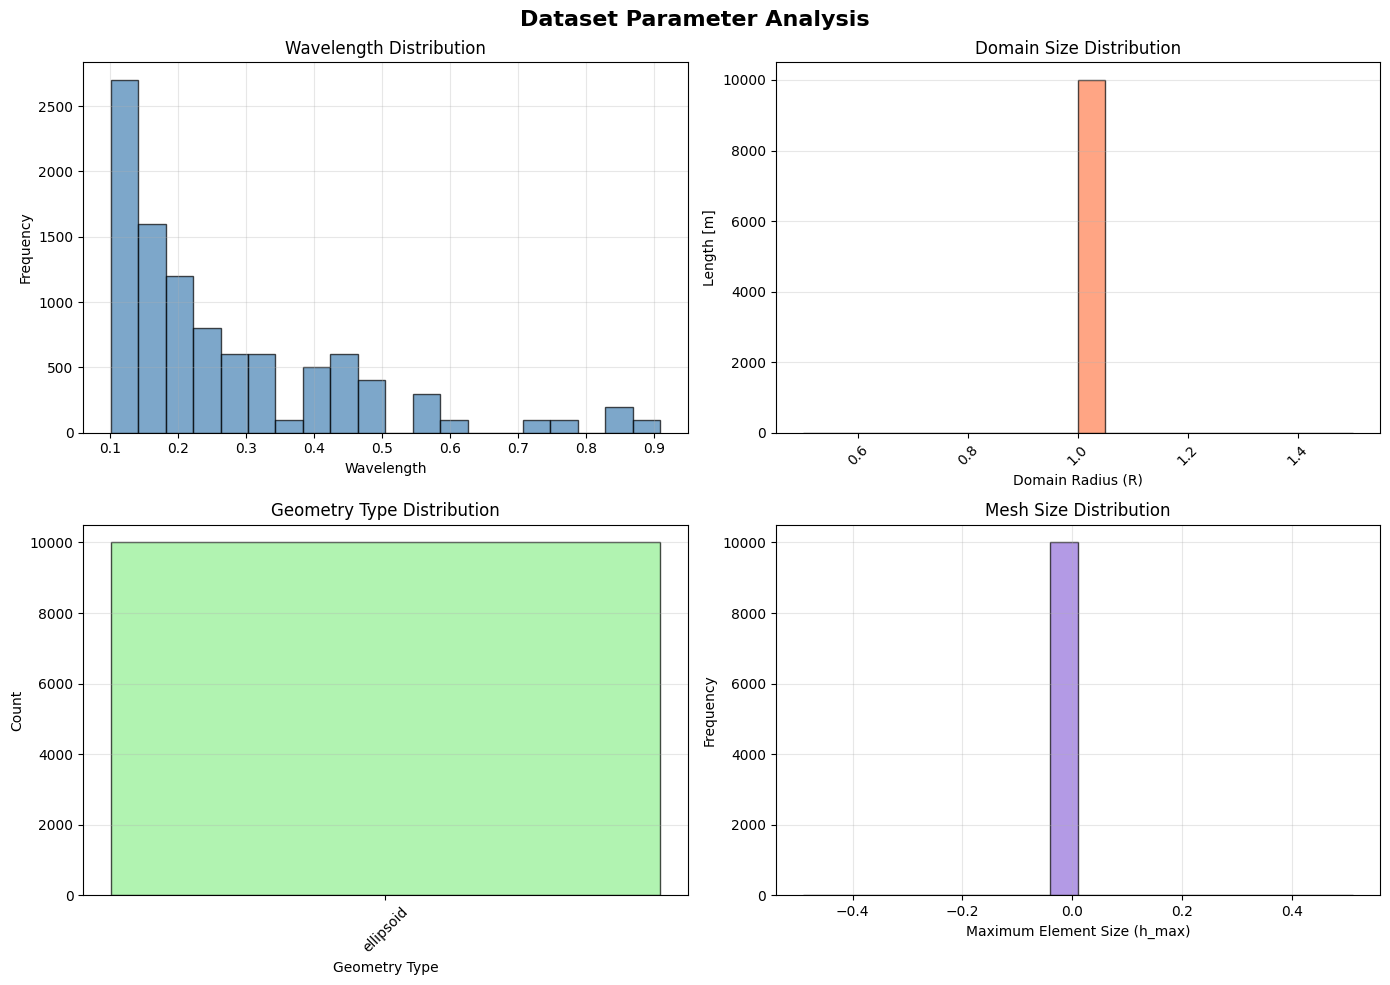


Plot saved to ./bin/imgs/dataset_overview.png


In [47]:
#print("\n" + "=" * 70)
#print("VISUALIZATIONS")
#print("=" * 70)

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Dataset Parameter Analysis', fontsize=16, fontweight='bold')

# 1. Wavelength distribution
wavelengths = [job['parameters']['wavelength'] for job in jobs]
axes[0, 0].hist(wavelengths, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Wavelength')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Wavelength Distribution')
axes[0, 0].grid(True, alpha=0.3)

# 2. Problem type distribution
problem_types_list = [job.get('problem_type', 'unknown') for job in jobs]
prob_counts = Counter(problem_types_list)
axes[0, 1].hist(domain_radius, bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Domain Radius (R)')
axes[0, 1].set_ylabel('Length [m]')
axes[0, 1].set_title('Domain Size Distribution')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Geometry type distribution
geometry_types_list = [job['geometry']['type'] for job in jobs]
geom_counts = Counter(geometry_types_list)
axes[1, 0].bar(geom_counts.keys(), geom_counts.values(), color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Geometry Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Geometry Type Distribution')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Mesh size (h_max) distribution
h_max_values = [job['geometry'].get('h_max', np.nan) for job in jobs]
h_max_values = [v for v in h_max_values if not np.isnan(v)]
axes[1, 1].hist(h_max_values, bins=20, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Maximum Element Size (h_max)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Mesh Size Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./bin/imgs/dataset_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to ./bin/imgs/dataset_overview.png")

In [48]:
# Create detailed parameter summary table
print("=" * 70)
print("PARAMETER VALUE SUMMARY TABLE")
print("=" * 70)

# Extract numeric parameters
numeric_params = defaultdict(list)
for job in jobs:
    params = job['parameters']
    for key, value in params.items():
        if isinstance(value, (int, float)):
            numeric_params[key].append(value)
    
    # Also include geometry parameters
    geom = job['geometry']
    for key, value in geom.items():
        if isinstance(value, (int, float)) and key != 'type':
            numeric_params[f"geom_{key}"].append(value)

# Create summary DataFrame
summary_data = []
for param_name, values in sorted(numeric_params.items()):
    summary_data.append({
        'Parameter': param_name,
        'Count': len(values),
        'Mean': np.mean(values),
        'Std Dev': np.std(values),
        'Min': np.min(values),
        'Max': np.max(values),
        'Q1': np.percentile(values, 25),
        'Median': np.median(values),
        'Q3': np.percentile(values, 75),
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Validation checks
print("\n" + "=" * 70)
print("DATASET VALIDATION CHECKS")
print("=" * 70)

validation_issues = []

# Check 1: All jobs have unique IDs
job_ids = [job.get('job_id') for job in jobs]
if len(job_ids) != len(set(job_ids)):
    validation_issues.append("⚠️  Duplicate job IDs found!")
else:
    print("\n✓ All jobs have unique IDs")

# Check 2: All jobs have required fields
required_fields = ['job_id', 'problem_type', 'parameters', 'geometry', 'solver']
for job_idx, job in enumerate(jobs):
    missing = [f for f in required_fields if f not in job]
    if missing:
        validation_issues.append(f"⚠️  Job {job_idx} missing fields: {missing}")

if not any("missing fields" in issue for issue in validation_issues):
    print("✓ All jobs have required fields")

# Check 3: Verify propagation direction and polarization are normalized
print("\nChecking vector normalizations:")
non_normalized = []
for job in jobs:
    params = job['parameters']
    
    # Check propagation direction
    prop_dir = np.array(params.get('propagation_dir', []))
    if len(prop_dir) == 3:
        prop_norm = np.linalg.norm(prop_dir)
        if not np.isclose(prop_norm, 1.0, atol=1e-6):
            non_normalized.append(f"Job {job['job_id']}: propagation_dir norm = {prop_norm:.6f}")
    
    # Check polarization
    pol = np.array(params.get('polarization', []))
    if len(pol) == 3:
        pol_norm = np.linalg.norm(pol)
        if not np.isclose(pol_norm, 1.0, atol=1e-6):
            non_normalized.append(f"Job {job['job_id']}: polarization norm = {pol_norm:.6f}")

if non_normalized:
    print(f"⚠️  {len(non_normalized)} vectors not normalized:")
    for msg in non_normalized[:5]:
        print(f"  {msg}")
    if len(non_normalized) > 5:
        print(f"  ... and {len(non_normalized) - 5} more")
else:
    print("✓ All direction vectors are properly normalized")

# Check 4: Verify orthogonality of propagation and polarization
print("\nChecking propagation-polarization orthogonality:")
non_orthogonal = []
for job in jobs:
    params = job['parameters']
    prop_dir = np.array(params.get('propagation_dir', []))
    pol = np.array(params.get('polarization', []))
    
    if len(prop_dir) == 3 and len(pol) == 3:
        dot_product = np.dot(prop_dir, pol)
        if not np.isclose(dot_product, 0.0, atol=1e-6):
            non_orthogonal.append(f"Job {job['job_id']}: dot product = {dot_product:.6f}")

if non_orthogonal:
    print(f"⚠️  {len(non_orthogonal)} jobs with non-orthogonal vectors:")
    for msg in non_orthogonal[:5]:
        print(f"  {msg}")
    if len(non_orthogonal) > 5:
        print(f"  ... and {len(non_orthogonal) - 5} more")
else:
    print("✓ All propagation and polarization vectors are orthogonal")

# Summary
if validation_issues:
    print(f"\n⚠️  Found {len(validation_issues)} validation issue(s)")
    for issue in validation_issues:
        print(f"  {issue}")
else:
    print("\n✅ Dataset validation passed!")

PARAMETER VALUE SUMMARY TABLE

            Parameter  Count     Mean  Std Dev      Min      Max       Q1   Median       Q3
ellipsoid_semi_axis_a  10000 0.259620 0.123659 0.050646 0.494914 0.178178 0.239309 0.342082
ellipsoid_semi_axis_b  10000 0.264786 0.120942 0.050955 0.497214 0.165202 0.266002 0.367967
ellipsoid_semi_axis_c  10000 0.276638 0.117796 0.050081 0.499438 0.182165 0.268073 0.360587
            geom_PMLw  10000 0.250000 0.000000 0.250000 0.250000 0.250000 0.250000 0.250000
               geom_R  10000 1.000000 0.000000 1.000000 1.000000 1.000000 1.000000 1.000000
     geom_curve_order  10000 5.000000 0.000000 5.000000 5.000000 5.000000 5.000000 5.000000
           geom_h_max  10000 0.010000 0.000000 0.010000 0.010000 0.010000 0.010000 0.010000
           wavelength  10000 0.268247 0.181811 0.100231 0.908601 0.132682 0.203253 0.343415

DATASET VALIDATION CHECKS

✓ All jobs have unique IDs
✓ All jobs have required fields

Checking vector normalizations:
✓ All direction vecto

## ============================================================================
# 2. MESH STATISTICS
## ============================================================================

In [ ]:
mesh_stats = []
for jid in trange(len(jobs)):
    job = jobs[jid]
    params = job['parameters']
    geometry_config = job['geometry']
    
    mesh,geometry_type = create_geometry(geometry_config, params, verbose=False)

    mesh_stats.append({'type': geometry_config['type'], 'elements': mesh.ne, 'vertices': mesh.nv, 'edges': mesh.nedge, 'h_max': geometry_config['h_max'], 'R': geometry_config['R'], 'PMLw': geometry_config['PMLw']})

  0%|                                                                                                                                                         | 0/10000 [00:00<?, ?it/s]

In [26]:
# Analyze mesh statistics
print("\n" + "=" * 70)
print("MESH STATISTICS ANALYSIS")
print("=" * 70)

mesh_df = pd.DataFrame(mesh_stats)

print(f"\nMesh statistics summary:")
print(f"  Total successful meshes: {len(mesh_df)}")
print(f"  Number of elements - Mean: {mesh_df['elements'].mean():.0f}, "
      f"Std: {mesh_df['elements'].std():.0f}, "
      f"Min: {mesh_df['elements'].min()}, Max: {mesh_df['elements'].max()}")
print(f"  Number of vertices - Mean: {mesh_df['vertices'].mean():.0f}, "
      f"Std: {mesh_df['vertices'].std():.0f}, "
      f"Min: {mesh_df['vertices'].min()}, Max: {mesh_df['vertices'].max()}")

# Statistics by geometry type
print(f"\nMesh statistics by geometry type:")
for geom_type in sorted(mesh_df['type'].unique()):
    geom_data = mesh_df[mesh_df['type'] == geom_type]
    print(f"\n  {geom_type} ({len(geom_data)} meshes):")
    print(f"    Elements - Mean: {geom_data['elements'].mean():.0f}, "
          f"Min: {geom_data['elements'].min()}, Max: {geom_data['elements'].max()}")
    print(f"    Vertices - Mean: {geom_data['vertices'].mean():.0f}, "
          f"Min: {geom_data['vertices'].min()}, Max: {geom_data['vertices'].max()}")

# Correlation between mesh size parameters and number of elements
print(f"\nCorrelation analysis:")
correlations = {
    'h_max vs elements': mesh_df['h_max'].corr(mesh_df['elements']),
    'outer_radius vs elements': mesh_df['R'].corr(mesh_df['elements']),
    'pml_width vs elements': mesh_df['PMLw'].corr(mesh_df['elements']),
}

for name, corr in correlations.items():
    if not np.isnan(corr):
        print(f"  {name}: {corr:.4f}")

# Create comprehensive mesh statistics table
print(f"\nDetailed mesh statistics table:")
mesh_summary = mesh_df.groupby('type').agg({
    'elements': ['mean', 'min', 'max', 'std'],
    'vertices': ['mean', 'min', 'max', 'std'],
    'h_max': ['mean', 'min', 'max'],
    'R': ['mean', 'min', 'max'],
    'PMLw': ['mean', 'min', 'max'],
}).round(2)

print("\n" + mesh_summary.to_string())


MESH STATISTICS ANALYSIS

Mesh statistics summary:
  Total successful meshes: 10
  Number of elements - Mean: 25265, Std: 7901, Min: 17567, Max: 39617
  Number of vertices - Mean: 5537, Std: 1464, Min: 4150, Max: 8191

Mesh statistics by geometry type:

  box (5 meshes):
    Elements - Mean: 27460, Min: 19442, Max: 33051
    Vertices - Mean: 5943, Min: 4431, Max: 6973

  ellipsoid (5 meshes):
    Elements - Mean: 23069, Min: 17567, Max: 39617
    Vertices - Mean: 5130, Min: 4150, Max: 8191

Correlation analysis:
  h_max vs elements: 0.0000

Detailed mesh statistics table:

          elements                        vertices                      h_max                R            PMLw            
              mean    min    max      std     mean   min   max      std  mean   min   max mean  min  max  mean   min   max
type                                                                                                                      
box        27460.2  19442  33051  6413.57   5942.8

/home/sebastian/VENVS/ma/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sebastian/VENVS/ma/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


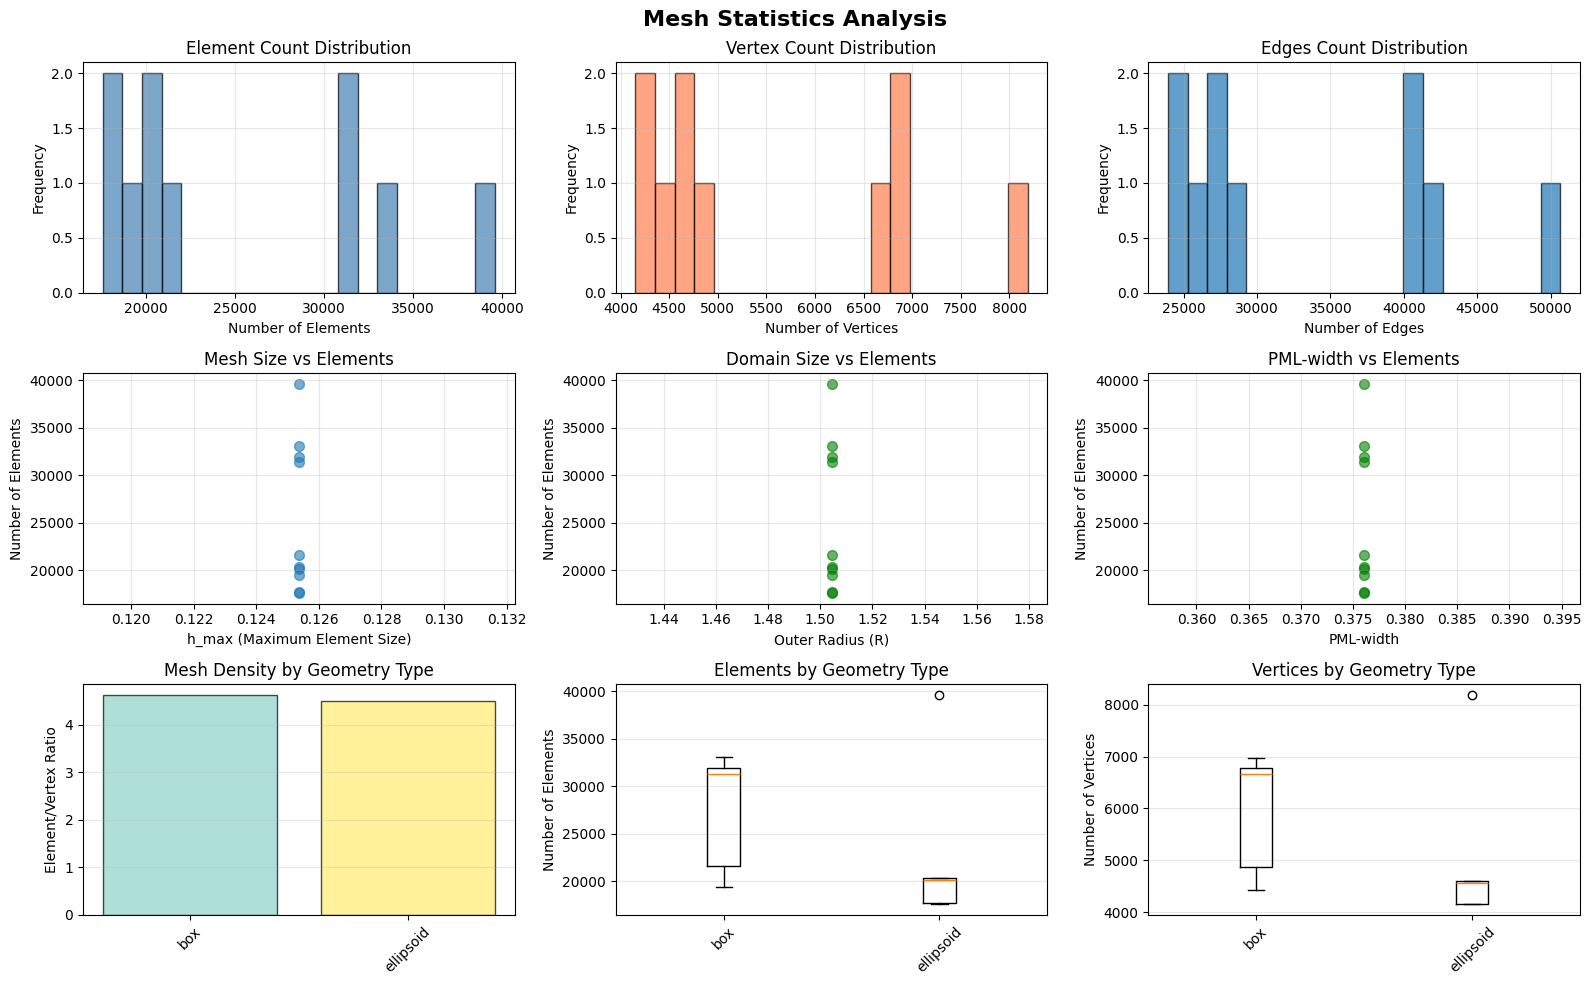


Plot saved to ./bin/imgs/mesh_statistics.png


In [36]:
# Visualizations for mesh statistics
#print("\n" + "=" * 70)
#print("MESH STATISTICS VISUALIZATIONS")
#print("=" * 70)

fig, axes = plt.subplots(3, 3, figsize=(16, 10))
fig.suptitle('Mesh Statistics Analysis', fontsize=16, fontweight='bold')

# 1. Elements distribution
axes[0, 0].hist(mesh_df['elements'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Elements')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Element Count Distribution')
axes[0, 0].grid(True, alpha=0.3)

# 2. Vertices distribution
axes[0, 1].hist(mesh_df['vertices'], bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Vertices')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Vertex Count Distribution')
axes[0, 1].grid(True, alpha=0.3)

# 3. Edges distribution
axes[0, 2].hist(mesh_df['edges'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Number of Edges')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Edges Count Distribution')
axes[0, 2].grid(True, alpha=0.3)

# 4. h_max vs elements (scatter)
axes[1, 0].scatter(mesh_df['h_max'], mesh_df['elements'], alpha=0.6, s=50)
axes[1, 0].set_xlabel('h_max (Maximum Element Size)')
axes[1, 0].set_ylabel('Number of Elements')
axes[1, 0].set_title('Mesh Size vs Elements')
axes[1, 0].grid(True, alpha=0.3)

# 5. outer_radius vs elements (scatter)
axes[1, 1].scatter(mesh_df['R'], mesh_df['elements'], alpha=0.6, s=50, color='green')
axes[1, 1].set_xlabel('Outer Radius (R)')
axes[1, 1].set_ylabel('Number of Elements')
axes[1, 1].set_title('Domain Size vs Elements')
axes[1, 1].grid(True, alpha=0.3)

# 6. PMLw vs elements (scatter)
axes[1, 2].scatter(mesh_df['PMLw'], mesh_df['elements'], alpha=0.6, s=50, color='green')
axes[1, 2].set_xlabel('PML-width')
axes[1, 2].set_ylabel('Number of Elements')
axes[1, 2].set_title('PML-width vs Elements')
axes[1, 2].grid(True, alpha=0.3)

# 7. Elements/Vertices ratio by geometry type
geom_stats = mesh_df.groupby('type').apply(
    lambda x: (x['elements'].mean() / x['vertices'].mean()), include_groups=False
)
colors_geom = plt.cm.Set3(np.linspace(0, 1, len(geom_stats)))
axes[2, 0].bar(range(len(geom_stats)), geom_stats.values, color=colors_geom, edgecolor='black', alpha=0.7)
axes[2, 0].set_xticks(range(len(geom_stats)))
axes[2, 0].set_xticklabels(geom_stats.index, rotation=45)
axes[2, 0].set_ylabel('Element/Vertex Ratio')
axes[2, 0].set_title('Mesh Density by Geometry Type')
axes[2, 0].grid(True, alpha=0.3, axis='y')

# 8. Elements by geometry type (box plot)
geometry_types_list = mesh_df['type'].unique()
elements_by_type = [mesh_df[mesh_df['type'] == gt]['elements'].values 
                    for gt in sorted(geometry_types_list)]
axes[2, 1].boxplot(elements_by_type, tick_labels=sorted(geometry_types_list))
axes[2, 1].set_ylabel('Number of Elements')
axes[2, 1].set_title('Elements by Geometry Type')
axes[2, 1].tick_params(axis='x', rotation=45)
axes[2, 1].grid(True, alpha=0.3, axis='y')

# 9. Vertices by geometry type (box plot)
geometry_types_list = mesh_df['type'].unique()
elements_by_type = [mesh_df[mesh_df['type'] == gt]['vertices'].values 
                    for gt in sorted(geometry_types_list)]
axes[2, 2].boxplot(elements_by_type, tick_labels=sorted(geometry_types_list))
axes[2, 2].set_ylabel('Number of Vertices')
axes[2, 2].set_title('Vertices by Geometry Type')
axes[2, 2].tick_params(axis='x', rotation=45)
axes[2, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./bin/imgs/mesh_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to ./bin/imgs/mesh_statistics.png")